## Dataset Information

[XR-bones Dataset for Bone Fracture Detection](https://www.kaggle.com/datasets/japeralrashid/xr-bones-dataset-for-bone-fracture-detection/data)

Overview
The XR-bones dataset is a comprehensive collection of X-ray images designed to facilitate research and development in bone fracture detection using computer vision techniques. This dataset contains X-ray images categorized into two main classes: negative (no fracture) and positive (fracture present). The data is further organized by specific anatomical regions, ensuring a diverse and detailed representation of bone fractures.

Classes
The dataset is divided into the following categories:

Negative Classes (No Fracture):
1. XR_ELBOW_negative
2. XR_FINGER_negative
3. XR_FOREARM_negative
4. XR_HAND_negative
5. XR_SHOULDER_negative

Positive Classes (Fracture Present):
1. XR_ELBOW_positive
2. XR_FINGER_positive
3. XR_FOREARM_positive
4. XR_HAND_positive
5. XR_SHOULDER_positive

Validation Data:

In addition to the main dataset, a validation set is provided to evaluate model performance. The validation set includes 100 images randomly selected from each class, along with their corresponding labels and bounding box annotations.

- Validation Directories:
- - validation_classes
- - validation_labels

Applications

The XR-bones dataset is ideal for developing and evaluating automated bone fracture detection algorithms. Potential applications include:

- Medical Diagnostics: Assisting radiologists in detecting fractures quickly and accurately.
- Research: Facilitating research in computer vision, deep learning, and medical image analysis.
- Education: Serving as a valuable resource for educational purposes in medical and technological fields.
Usage

To use this dataset, follow these steps:

1. Download the Dataset: Ensure you have sufficient storage space and a reliable internet connection.
2. Extract the Files: Unzip the downloaded files to access the images and CSV annotations.
3. Load the Data: Use appropriate data loading techniques to read the images and annotations into your machine learning pipeline.
4. Train and Evaluate Models: Utilize the dataset to train and evaluate bone fracture detection models using techniques such as Convolutional Neural Networks (CNNs) and other machine learning algorithms.

## Calculate distribution of labels

In [1]:
import cv2
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [2]:
# ROOT_DIR = 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\bonefractureyolo'
ROOT_DIR = 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet'
IMAGE_DIR = Path(ROOT_DIR).joinpath('images')
TRAIN_DIR = Path(IMAGE_DIR).joinpath('train')

In [ ]:
image_paths = [imgPath for imgPath in TRAIN_DIR.glob('*.png')]

image_paths[:5]

[WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_10.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_100.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1000.png'),
 WindowsPath('C:/Users/User/Desktop/Data_Science_Notebook/projects/project__bone_fracture_detection/YOLODataSet/images/train/XR_ELBOW_negative_1001.png')]

In [7]:
def check_multi_lines_files(image_paths):
    multi_lines = []
    for image_path in image_paths:
        label_path = str(image_path).replace('images', 'labels').replace('.png', '.txt')
        try:
            with open(label_path, 'r') as file:
                lines = file.readlines()  # Read all lines from the file
                if len(lines) >= 2:
                    multi_lines.append(label_path)
        except: continue
    print(f"There are {len(multi_lines)} files tha have more than one labels!")

    return multi_lines

multi_lines = check_multi_lines_files(image_paths)
multi_lines

There are 30 files tha have more than one labels!


['C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet\\labels\\train\\XR_FOREARM_positive_315.txt',
 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet\\labels\\train\\XR_HAND_positive_113.txt',
 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet\\labels\\train\\XR_HAND_positive_1147.txt',
 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet\\labels\\train\\XR_SHOULDER_positive_1.txt',
 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet\\labels\\train\\XR_SHOULDER_positive_1006.txt',
 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_detection\\YOLODataSet\\labels\\train\\XR_SHOULDER_positive_1007.txt',
 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__bone_fracture_

In [9]:
ex_path = random.choice(multi_lines)
print(ex_path)

with open(ex_path, 'r') as file:
    lines = file.readlines()  # Read all lines from the file

lines

C:\Users\User\Desktop\Data_Science_Notebook\projects\project__bone_fracture_detection\YOLODataSet\labels\train\XR_SHOULDER_positive_105.txt


['4 0.441406 0.307143 0.250000 0.114286\n',
 '4 0.443359 0.376190 0.382812 0.385714\n']

In [ ]:
def load_label_file(label_path:str) -> list:
    """
    Load label data from a file and convert it into a list of rectangles with their labels.

    Args:
        label_path (str): The path to the label file.

    Returns:
        list: A list of tuples, where each tuple contains:
              - label (float): The label of the rectangle.
              - coordinates (tuple): A tuple (x_min, y_min, x_max, y_max) representing
                the bounding box of the rectangle.
    """
    rectangles = []  # List to store rectangles with their positions
    label = '' # labels
    with open(label_path, 'r') as file:
        lines = file.readlines()  # Read all lines from the file
        for line in lines:
            # Parse the line into a list of float values
            info = [float(ele) for ele in line.split()]
            
            # The first value is the label
            if not label:
                label = int(info[0])
            coords = info[1:]  # The remaining values are coordinate information
            
            # Extract x-coordinates (even-indexed) and y-coordinates (odd-indexed)
            x_coords = coords[::2]  # x-coordinate values
            y_coords = coords[1::2]  # y-coordinate values
            
            # Calculate the bounding box (min and max values of x and y coordinates)
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            
            # Append the label and bounding box to the rectangles list
            rectangles.append((label, (x_min, y_min, x_max, y_max)))
    
    return (label, rectangles)  # Return the list of labeled rectangles

In [ ]:
# image_path = random.choice(image_paths)
images = []
labels = []
for image_path in image_paths:
    label_path = str(image_path).replace('images', 'labels').replace('.png', '.txt')
    try:
        label, rectangle = load_label_file(label_path)
        if label:
            images.append((image_path, rectangle))
            labels.append(label)
    except: continue

len(images), len(labels)

(18652, 18652)

In [16]:
dataset = {}

for label in labels:
    if label not in dataset:
        dataset[label] = 0
    dataset[label] += 1

dataset

{5: 2764, 6: 2930, 1: 1756, 7: 1056, 2: 522, 8: 3839, 3: 912, 9: 4000, 4: 873}

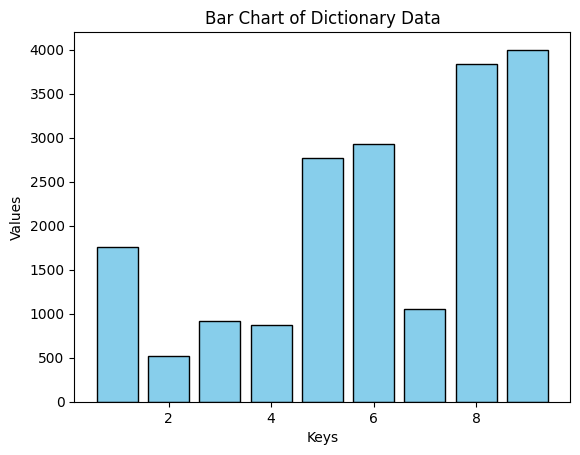

In [17]:
# Extract keys and values
keys = []
values = []

for key, value in dataset.items():
    keys.append(key)
    values.append(value)

# Create the bar chart
plt.bar(keys, values, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Bar Chart of Dictionary Data')

# Display the chart
plt.show()

## Images Visualization

In [18]:
def plot_multiple_images_with_rectangles(images_selected:list):
    """
    Plot multiple images with their rectangle annotations in a grid using matplotlib.
    
    Args:
        images_selected (list): A list of tuples where each tuple contains:
                                - imgPath (str): Path to the image file.
                                - rectangles (list): A list of rectangles, where each rectangle is a tuple:
                                                     (label, (x_min, y_min, x_max, y_max)).
    """
    # Calculate the side length of the grid (assume the number of images is a perfect square)
    side = np.sqrt(len(images_selected)).astype(np.int32)

    # Create a grid of subplots
    fig, axes = plt.subplots(side, side, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for idx, (imgPath, rectangles) in enumerate(images_selected):
        # Read the image using OpenCV
        image = cv2.imread(imgPath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for matplotlib
        height, width, _ = image.shape  # Get image dimensions

        # Plot the image in the current subplot
        ax = axes[idx]
        ax.imshow(image)
        ax.axis('off')  # Turn off axes for a cleaner visualization

        # Draw each rectangle and its label on the image
        for label, (x_min, y_min, x_max, y_max) in rectangles:
            # Convert relative coordinates to pixel coordinates
            x_min_pixel, y_min_pixel = int(x_min * width), int(y_min * height)
            x_max_pixel, y_max_pixel = int(x_max * width), int(y_max * height)

            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min_pixel, y_min_pixel),  # (x, y) of the rectangle's bottom-left corner
                x_max_pixel - x_min_pixel,  # Width of the rectangle
                y_max_pixel - y_min_pixel,  # Height of the rectangle
                linewidth=2, edgecolor='red', facecolor='none'  # Red border, no fill color
            )
            ax.add_patch(rect)  # Add the rectangle to the current subplot

            # Add the label text near the top-left corner of the rectangle
            ax.text(
                x_min_pixel, y_min_pixel - 10, f"Label {label}",  # Position text slightly above the rectangle
                color='green', fontsize=8, backgroundcolor='white'  # Green text with white background
            )

        # Add a title for the subplot
        ax.set_title(f"Image {idx + 1}")

    # Hide any unused axes (in case the number of images is less than the grid size)
    for ax in axes[len(images_selected):]:
        ax.axis('off')

    # Adjust layout for better spacing and show the figure
    plt.tight_layout()
    plt.show()

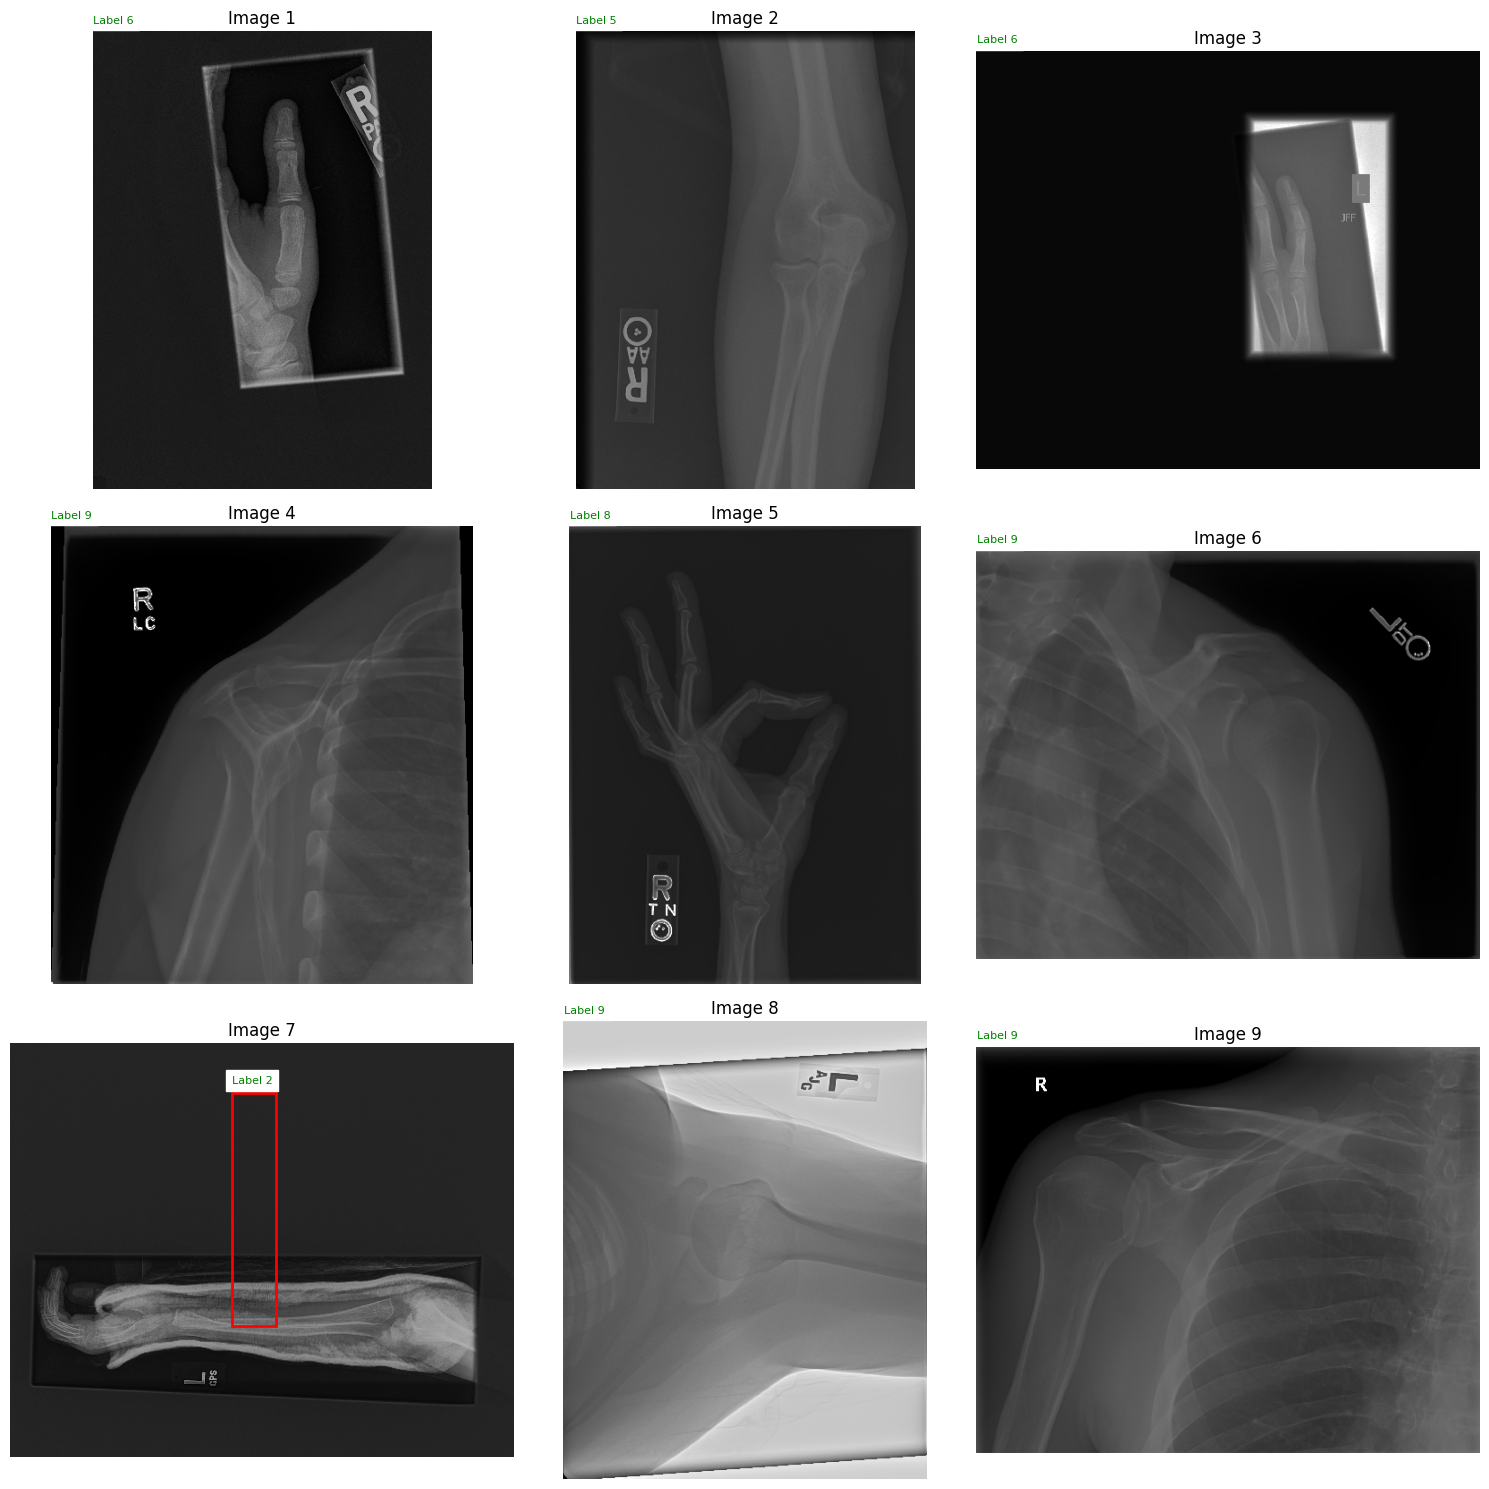

In [24]:
images_selected = random.choices(images, k=9)
plot_multiple_images_with_rectangles(images_selected)